---------------------
# FOOD DEMAND FORECASTING : *SUPPLY CHAIN ANALYTICS* 
---------------------   

*  Nitanshu Joshi - nitjoshi
*  Aditi Soni - adisoni
*  Melissa Mathias - melmath

In [ ]:
# # Installations
# # -------------
!pip install catboost
!pip install eli5

In [ ]:
# Imports
# =======

# Basic
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Displaying maximum Rows and Columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


# SKLearn Imports

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import explained_variance_score
from sklearn.neighbors import KNeighborsRegressor

# Statistics Imports
from statistics import mean, stdev

# Boosting Imports
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import xgboost
from xgboost import XGBRegressor
from scipy.stats import randint as sp_randint
import random


## About the Datasets
--------------------------

### The Data Dictionaries can be found below.

## **`Dataset 1 --> "train" dataset`** :-->
<br><br>


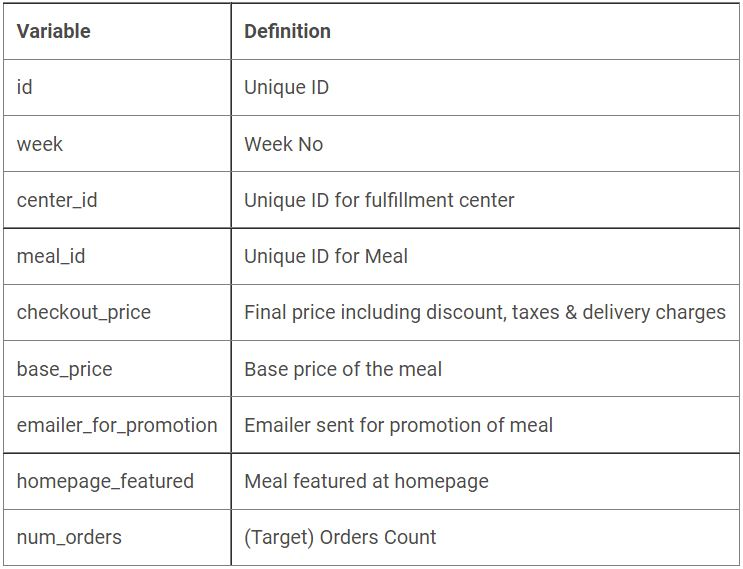

<br>

## **`Dataset 2 --> "meal_info" dataset`** :-->
<br><br>

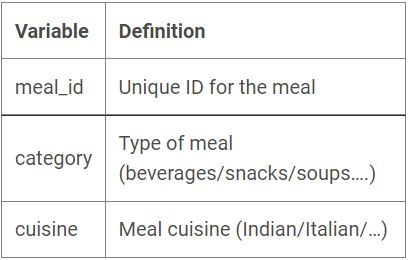

<br>

## **`Dataset 3 --> "meal_fulfilment" dataset`** :-->
<br><br>

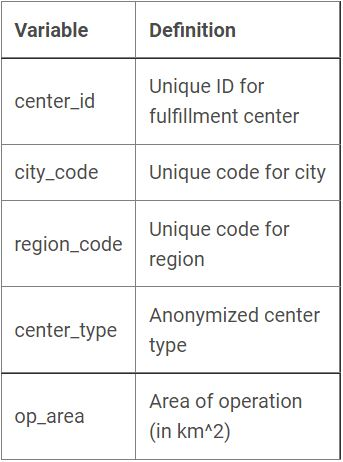

<br><br>

In [ ]:
# Reading and Creating the Training Dataset
# -----------------------------------------
print("Training Data : ")
print("=============")

df_av = pd.read_csv('train.csv')
df_av_mealinfo = pd.read_csv('meal_info.csv')
df_av_fulfilmentcenterinfo = pd.read_csv('fulfilment_center_info.csv')
display(df_av.head())
display(df_av_mealinfo.head())
display(df_av_fulfilmentcenterinfo.head())
print("\n")

In [ ]:
print("Shape of Train (original)        : ", df_av.shape)
print("Shape of Meal Info               : ", df_av_mealinfo.shape)
print("Shape of Fulfilment Center Info  : ", df_av_fulfilmentcenterinfo.shape)

In [ ]:
# We have the following datasets available with us
# ------------------------------------------------
# > Training Data: Prices (Base & Checkout), Promotion Information
# > Meal Information Data: Contains Information on meal id, categories and cuisines.
# > Fulfilment Center Information Data: Contains Information City, Center, Regions, and Areas

# We need to merge them in order to proceed.

# Merging
# =======
df_final = df_av.merge(df_av_mealinfo, on="meal_id", how = 'inner')
df_final = df_final.merge(df_av_fulfilmentcenterinfo, on='center_id', how = 'inner')
print("Final Training Dataset: \n")
display(df_final.head())
print("\n\nShape of Final Training Dataset:", df_final.shape)

In [ ]:
# We can observe a huge number of rows in the dataset.

# We will come back to testing dataset, when predicting using a model.
# Also, we will also be creating new features for the Testing set along with the Training Set

# We will start working with the training model.

----------------------------------------
## Working with the Training Data:
----------------------------------------

In [ ]:
df_final.info()

In [ ]:
# We observe that most of the columns are numerical and three (3) of the columns are categorical.

In [ ]:
# Setting ID as index
# -------------------
df_final.set_index('id', inplace=True)
df_final.head()

## <font color = 'magenta'> Step 2 - Data Cleaning and Feature Engineering </font>

### 2.1) Checking for Null values:
---------------------------

In [ ]:
df_final.isnull().sum()

In [ ]:
# We observe that there are no Null values in the Dataset.
# So Null value analysis is not needed.

### 2.3) Outlier Analysis:
---------------------------

In [ ]:
# Looking at the Statistical Features of the Numerical Features
# -------------------------------------------------------------
numerical_columns = ["base_price", "op_area", "checkout_price"]
df_final[numerical_columns].describe()

In [ ]:
# We can see that there are no visible outliers in the data.
# To be more certain, we can plot the boxplots for the same

plt.figure(figsize=(20, 10))

plt.subplot(1,3,1)
sns.boxplot(y = 'base_price', data=df_final)
plt.title("Base Price")

plt.subplot(1,3,2)
sns.boxplot(y = 'op_area', data=df_final)
plt.title("Operation Area")

plt.subplot(1,3,3)
sns.boxplot(y = 'checkout_price', data=df_final)
plt.title("Checkout Price")

plt.show()


In [ ]:
# Looking at these we can see no major outliers present in the data.
# So no outlier analysis is required.

### 2.4) Refactoring old features to new format
-----------------------------------

In [ ]:
def promotion(x):
    return x.map({1:"Promotion through Email", 0:"No Email Promotion"})
df_final[["emailer_for_promotion"]] = df_final[["emailer_for_promotion"]].apply(promotion)

def homepage(x):
    return x.map({0:"Not Featured", 1:"Featured on Homepage"})
df_final[["homepage_featured"]] = df_final[["homepage_featured"]].apply(homepage)    


# Creating a Weeks column with bucket ranges of 20 weeks for Exploratory Data Analysis.
def weeks(x):
    if x <= 20:
        return "Week 1-20"
    elif x > 20 and x <= 40:
        return "Week 21-40"
    elif x > 40 and x <= 60:
        return "Week 41-60"
    elif x > 60 and x <= 80:
        return "Week 61-80"
    elif x > 80 and x <= 100:
        return "Week 81-100"    
    elif x > 100 and x <= 120:
        return "Week 101-120"
    elif x > 120 and x <= 140:
        return "Week 121-140"    
    else:
        return "Week 141 and later"
df_final['weeks_of_20'] = df_final['week'].apply(weeks)
#df_test['weeks_of_20'] = df_test['week'].apply(weeks)

In [ ]:
df_final.head()

### 2.5) Deriving NEW features from existing data
-----------------------------------

In [ ]:
# Creating a variable - "Discount Offered to Customers" 
# -----------------------------------------------------
def discount_function_1(x):
    if x > 0: return x
    else: return 0

df_final['discount_offered'] = df_final['base_price'] - df_final['checkout_price']
df_final['discount_offered'] = df_final['discount_offered'].apply(discount_function_1)

# Creating a profit column - "Profit earned by the center"
# -------------------------------------------------------
df_final['profit_earned'] = df_final['checkout_price'] - df_final['base_price']
df_final['profit_earned'] = df_final['profit_earned'].apply(discount_function_1)
df_final.head()


# df_test['discount_offered'] = df_test['base_price'] - df_test['checkout_price']
# df_test['discount_offered'] = df_test['discount_offered'].apply(discount_function_1)
# df_test['profit_earned'] = df_test['checkout_price'] - df_test['base_price']
# df_test['profit_earned'] = df_test['profit_earned'].apply(discount_function_1)

In [ ]:
## Sorting based on center_id, meal_id and week
# df_final = df_final.sort_values(['center_id', 'meal_id', 'week']).reset_index()

In [ ]:
#Compare Week Price - weekly price diff in checkout
# -------------------------------------------------------
df_final['compare_week_price'] = df_final['checkout_price'] - df_final['checkout_price'].shift(1) 
df_final['compare_week_price'][df_final['week']==1]=0

# df_test['compare_week_price'] = df_test['checkout_price'] - df_test['checkout_price'].shift(1) 
# df_test['compare_week_price'][df_test['week']==1]=0

#df_final=df_final.sort_values(by='index').reset_index().drop(['level_0','index'],axis=1)

# Compare Week Price Y/N  - was there a difference?
# -------------------------------------------------------
df_final['compare_week_price y/n'] = [1 if x>0 else 0 for x in df_final['compare_week_price']]
#df_test['compare_week_price y/n'] = [1 if x>0 else 0 for x in df_test['compare_week_price']]

df_final.head()

In [ ]:
df_final.isnull().sum()

In [ ]:
# Still we don't have any Null values

### <font color = 'magenta'> Step 3 - Exploratory Data Analysis and Visualization using plots </font>

In [ ]:
# Research Questions to answer with EDA:
# -------------------------------------
# > How the food order demand is increasing as we move on to further weeks?
# > How cuisines are impacting the demand of orders?
# > Does promotion impact the number of orders?
# ----------------------------------------------------------------------------

In [ ]:
# How the food order demand is increasing as we move on to further weeks
# ----------------------------------------------------------------------
plt.figure(figsize=(20,7))
sns.barplot(x = df_final['weeks_of_20'], y = df_final['num_orders'])
plt.xlabel('Weeks in multiples of 20')
plt.ylabel('Number of Orders')
plt.title("Weeks vs Number of Orders")
plt.show()

In [ ]:
# Here we have cumulated the number of weeks in bins of 20 weeks each as we had data worth of 140 weeks, 
# to show the average number of orders which were received over the weeks, 
# the chart interprets that there is almost a constant flow of orders from the time data has been collected, 
# which not much of crests and troughs.
# 
# Nothing much can be said about the increase or decrease in the number of orders based on the passing of weeks.
# The number of orders are not dependent on the number of orders

In [ ]:
# Impact on cuisines on number of orders:
# --------------------------------------
plt.figure(figsize=(10,7))
sns.barplot(df_final['cuisine'],df_final['num_orders']) # Estimator = Mean
plt.xlabel('Type of Cuisine')
plt.ylabel('Number of Orders')
plt.title("Types of Cuisines vs Number of Orders")
plt.show()

In [ ]:
# Observations
# ------------
# It can be seen the "Italian" cuisines have the most demand among customers whereas 'continental' has the least.

In [ ]:
# Promotions with the number of orders
# ------------------------------------
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sns.barplot(df_final['emailer_for_promotion'],df_final['num_orders']) # Estimator = Mean
plt.xlabel('Promotion through Emails')
plt.ylabel('Number of Orders')
plt.title("Email Promotion Status vs Number of Orders")
plt.subplot(1,2,2)
sns.barplot(df_final['homepage_featured'],df_final['num_orders']) # Estimator = Mean
plt.xlabel('Featured on Homepage')
plt.ylabel('Number of Orders')
plt.title("Homepage Promotion Status vs Number of Orders")
plt.show()

In [ ]:
# Observations
# ------------
# It can be observed that more featured and promoted the restaurants are, more are number of orders.

In [ ]:

# Impact of center type on number of orders:
# --------------------------------------
plt.figure(figsize=(10,7))
sns.barplot(y='num_orders', x='center_type', data=df_final.groupby('center_type').sum()['num_orders'].reset_index(),palette='autumn');
plt.ylabel('Number of Orders',)
plt.xlabel('Center Type',)
plt.title('Center type Vs. Number of Orders')
plt.show

In [ ]:
# With this barplot, we can see that maximum orders are received by Center of type A, 
# this is then followed by type B and demand is of type C centers.

In [ ]:
# Prices and their relation with the demand of orders
# ===================================================

plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
sns.scatterplot(df_final['checkout_price'],df_final['num_orders'])
plt.title("Checkout price v/s Number of Orders(Target)")
plt.xlabel('Checkout Price')
plt.ylabel('Number of Orders')

plt.subplot(1,2,2)
sns.scatterplot(df_final['base_price'],df_final['num_orders'])
plt.title("Base price v/s Number of Orders(Target)")
plt.xlabel('Base Price')
plt.ylabel('Number of Orders')

plt.show()

In [ ]:
# With this scatter plots, we highlight the average number of orders that go out 
# with the base prices and also with respect to prices that come after a discount 
# has been applied to them. 
#  Observations are as below: 
#    > number of meals that go out with the discounted prices is around $180-$190, 
#    > while most of the meals that go out with the base prices are the range of $290-$300.

------------------------------------------------
------------------------------------------------

---------------------------------------------
# Step 4 - Modelling using various Models
---------------------------------------------

In [ ]:
df_final_copy = df_final.copy()

In [ ]:
#df_final = df_final_copy.copy()

# Removing columns not Required for Modelling:
# -------------------------------------------
df_final.drop("weeks_of_20", axis=1, inplace=True)

In [ ]:
# Unique Values:
# -------------
print("Unique Center IDs        : ",df_final['center_id'].nunique())
print("Unique City Codes        : ",df_final['city_code'].nunique())
print("Unique Region Codes      : ",df_final['region_code'].nunique())
print("Unique Center Types      : ",df_final['center_type'].nunique())
print("Unique Cuisine Types     : ",df_final['cuisine'].nunique())
print("Unique Category Types    : ",df_final['category'].nunique())

In [ ]:
# Reconverting the two binary categorical columns back to original:
# ----------------------------------------------------------------
def email_prom_rev(x):
    return x.map({"No Email Promotion": 0, "Promotion through Email":1})
df_final[["emailer_for_promotion"]] = df_final[["emailer_for_promotion"]].apply(email_prom_rev)

def homepage_rev(x):
    return x.map({"Not Featured":0, "Featured on Homepage":1})
df_final[["homepage_featured"]] = df_final[["homepage_featured"]].apply(homepage_rev)   

df_final.head()

In [ ]:
df_final[["meal_id","city_code", "center_id", "region_code"]] = df_final[["meal_id","city_code", "center_id", "region_code"]].astype('str')

In [ ]:
# Creating a list of Categorical and Numerical Columns
# ----------------------------------------------------
categorical_col = ['center_id', 'meal_id', "city_code","region_code","category", "cuisine", "center_type"]
bin_categorical_col = ['emailer_for_promotion', 'homepage_featured', 'compare_week_price y/n']
numerical_col = ["base_price", "checkout_price", "op_area", "discount_offered",	"profit_earned", "compare_week_price", "week"]
target_column = 'num_orders'

In [ ]:
df_final.head()

In [ ]:
## Label Encoding
## --------------
label_encoder = LabelEncoder()    # Defining the label_encoder object.
df_final['center_id']= label_encoder.fit_transform(df_final['center_id'])
df_final['meal_id'] = label_encoder.fit_transform(df_final['meal_id'])
df_final['city_code'] = label_encoder.fit_transform(df_final['city_code'])
df_final['region_code'] = label_encoder.fit_transform(df_final['region_code'])

In [ ]:
# Creating a new list of Categorical and Numerical Columns
# --------------------------------------------------------
categorical_col = ["category", "cuisine", "center_type"]
bin_categorical_col = ['emailer_for_promotion', 'homepage_featured', 'compare_week_price y/n']
numerical_col = ["base_price", "checkout_price", "op_area", "discount_offered",	"profit_earned", 
                 "compare_week_price", "week", 'center_id', 'meal_id', "city_code","region_code"]
target_column = 'num_orders'

In [ ]:
# Plotting the HeatMaps
# ---------------------

plt.figure(figsize = (15,15))
num_col = ['num_orders',"base_price", "checkout_price", "op_area", "discount_offered",	"profit_earned", "compare_week_price", "week", 'center_id', 'meal_id', "city_code","region_code"]
corr_mat = df_final[num_col].corr(method='pearson')
sns.heatmap(corr_mat, annot = True, cmap = 'YlGnBu', mask=np.triu(corr_mat))
plt.show()

In [ ]:
# Observations:
# ------------
# It can be observed that Base price with checkout price 
#     shows a very high positive correlation between themselves.
# There is a high (+ve) correlation even between our target variable no_of_orders and op_id.
# Our target has the most (-ve) correlation with checkout_price(-0.18)

In [ ]:
# Creating Copies for Future Use
# ------------------------------
df  = df_final.copy()
df1 = df_final.copy()
df.shape

In [ ]:
# Creating a Dataframe to store performance metrics
# =================================================
performance_metrics = pd.DataFrame(columns=["Model Name", 
                                            "Hyperparameter Tuning", 
                                            "Train R-squared",
                                            "Test R-Squared", 
                                            "Test RMSE"])

### <font color = 'brown'> Model 1 - Linear Regression </font>
----------------------------

In [ ]:
# Copying the dataframe
df_final = df.copy()

# Encoding remaining Categorical Variables
# ========================================
dummied_df = pd.get_dummies(df_final[categorical_col], drop_first=True)     # Dummy Encoding/One-Hot Encoding
df_final.drop(categorical_col, axis=1, inplace=True)                        # Dropping the Cateogorical
df_final = pd.concat([df_final, dummied_df], axis=1)                        # Concatenating the Dummy Dataset 'df_dummies' with the main dataset 'df'

# Train-Test Split
# ----------------
df_train, df_test = train_test_split(df_final, train_size=0.8, random_state=10)

# Normalizing using min-max scalar
# --------------------------------
min_max_scalar = MinMaxScaler()
df_train[numerical_col] = min_max_scalar.fit_transform(df_train[numerical_col])
df_train[numerical_col].head()

# Spliting the Target and the predictor Variables
# -----------------------------------------------
X_train = df_train.drop("num_orders", axis = 1)
Y_train = df_train['num_orders']

# Defining The Model
# ------------------
lin_reg_model = LinearRegression(n_jobs = -1)

# Implementing K-Fold Cross Validation
np.random.seed(0)
kfold_lr = KFold(n_splits=15)

rmse_scores_lr = []
rsquared_lr = [0]
    
for train_index , test_index in kfold_lr.split(df_train):
    X_training = X_train.iloc[train_index,:]
    Y_training = Y_train.iloc[train_index]

    X_validation = X_train.iloc[test_index,:]
    Y_validation = Y_train.iloc[test_index]
    
    lin_reg_model.fit(X_training,Y_training)
    Y_validation_pred = lin_reg_model.predict(X_validation)

    r2 = r2_score(Y_validation, Y_validation_pred).round(3)
    if r2 >= max(rsquared_lr):
      best_lr_model = lin_reg_model   

    rsquared_lr.append(r2_score(Y_validation, Y_validation_pred).round(3))
    rmse_scores_lr.append(mean_squared_error(Y_validation, Y_validation_pred, squared=False))

rsquared_lr.pop(0)


# Predicting on Test Set using the Best Linear Regression Model
# -------------------------------------------------------------

# Rescaling Test Data:
df_test[numerical_col] = min_max_scalar.transform(df_test[numerical_col])

X_test = df_test.drop("num_orders", axis = 1)
Y_test = df_test['num_orders']

y_test_predict = best_lr_model.predict(X_test)

rsquared_train_lr = round(sum(rsquared_lr)/len(rsquared_lr), 3)
rsquared_test_lr = r2_score(Y_test, y_test_predict).round(3)
rmse_test_lr = mean_squared_error(Y_test, y_test_predict, squared=False).round(3)

print("Train: R-Squared Value         : ",rsquared_train_lr)
print("Test:  R-Squared Value         : ",rsquared_test_lr)
print("Test:  Root Mean Squared Error : ",rmse_test_lr)

In [ ]:
# Adding Scores to Metrics
# ------------------------
performance_metrics.loc[len(performance_metrics.index)] = ["Linear Regression", "No", 
                                                           rsquared_train_lr,
                                                           rsquared_test_lr ,
                                                           rmse_test_lr]                                                       
display(performance_metrics)

----------------------------
### <font color = 'brown'> **Model 2 - Linear Regression with Regularization - Ridge Regression** </font>
----------------------------

In [ ]:

df_ridge = df.copy()

# Encoding remaining Categorical Variables
# ========================================
# Dummy Encoding/One-Hot Encoding:
dummied_df = pd.get_dummies(df_ridge[categorical_col], drop_first=True)
# Dropping the Cateogorical
df_ridge.drop(categorical_col, axis=1, inplace=True)
# Concatenating the Dummy Dataset 'df_dummies' with the main dataset 'df_final'
df_ridge = pd.concat([df_ridge, dummied_df], axis=1)

# Train-Test Split
# ----------------
np.random.seed(0)   # We specify this so that the train and test data set always have the same rows, respectively.
df_train, df_test = train_test_split(df_ridge, train_size=0.8, random_state=10)

# Re-Scaling using min-max scalar
# -------------------------------
min_max_scalar = MinMaxScaler()
df_ridge[numerical_col] = min_max_scalar.fit_transform(df_ridge[numerical_col])
df_ridge[numerical_col].head()

# Spliting the Target and the predictor Variables.
# -----------------------------------------------
X_train = df_train.drop("num_orders", axis = 1)
Y_train = df_train['num_orders']

# Defining the Ridge Model
# ------------------------
ridge_model = Ridge(alpha=0.01, random_state=40, normalize=True, solver='saga')

# Implementing K-Fold Cross Validation
np.random.seed(0)
kfold_ridge = KFold(n_splits=15)

rmse_scores_ridge = []
rsquared_ridge = [0]
    
for train_index , test_index in kfold_ridge.split(df_train):
    X_training = X_train.iloc[train_index,:]
    Y_training = Y_train.iloc[train_index]

    X_validation = X_train.iloc[test_index,:]
    Y_validation = Y_train.iloc[test_index]
    
    ridge_model.fit(X_training,Y_training)
    Y_validation_pred = ridge_model.predict(X_validation)

    r2 = r2_score(Y_validation, Y_validation_pred).round(3)
    if r2 >= max(rsquared_ridge):
      best_ridge_model = ridge_model   

    rsquared_ridge.append(r2_score(Y_validation, Y_validation_pred).round(3))
    rmse_scores_ridge.append(mean_squared_error(Y_validation, Y_validation_pred, squared=False))

rsquared_ridge.pop(0)

# Predicting on Test Set:
# ----------------------
# Rescaling Test Data:
df_test[numerical_col] = min_max_scalar.transform(df_test[numerical_col])

X_test = df_test.drop("num_orders", axis = 1)
Y_test = df_test['num_orders']

y_test_predict = best_ridge_model.predict(X_test)

rsquared_train_ridge = round(sum(rsquared_ridge)/len(rsquared_ridge),3)
rsquared_test_ridge = r2_score(Y_test, y_test_predict).round(3)
rmse_test_ridge = mean_squared_error(Y_test, y_test_predict, squared=False).round(3)

print("Train: R-Squared Value         : ",rsquared_train_ridge)
print("Test:  R-Squared Value         : ",rsquared_test_ridge)
print("Test:  Root Mean Squared Error : ",rmse_test_ridge)

In [ ]:
# Adding Scores to Metrics
# ------------------------
performance_metrics.loc[len(performance_metrics.index)] = ["Ridge Regression", "No", 
                                                           rsquared_train_ridge,
                                                           rsquared_test_ridge,
                                                           rmse_test_ridge]
performance_metrics

----------------------------
### <font color = 'brown'> **Model 3 - Linear Regression with Regularization - Lasso Regression** </font>
----------------------------

In [ ]:
df_lasso = df1.copy()

# Encoding remaining Categorical Variables
# ----------------------------------------
dummied_df = pd.get_dummies(df_lasso[categorical_col], drop_first=True)     # Dummy Encoding/One-Hot Encoding
df_lasso.drop(categorical_col, axis=1, inplace=True)                        # Dropping the Cateogorical
df_lasso = pd.concat([df_lasso, dummied_df], axis=1)                        # Concatenating the Dummy Dataset 'df_dummies' with the main dataset 'df_final'

# Train-Test Split
# ----------------
np.random.seed(0)   # We specify this so that the train and test data set always have the same rows, respectively.
df_train, df_test = train_test_split(df_lasso, train_size=0.8, random_state=10)

# Re-Scaling using min-max scalar
# -------------------------------
min_max_scalar = MinMaxScaler()
df_lasso[numerical_col] = min_max_scalar.fit_transform(df_lasso[numerical_col])
df_lasso[numerical_col].head()

# Spliting the Target and the predictor Variables.
# -----------------------------------------------
X_train = df_train.drop("num_orders", axis = 1)
Y_train = df_train['num_orders']

# Recursive Feature Elminiation - to select 20 top features
# ---------------------------------------------------------
lasso_model = Lasso(alpha=0.01, random_state=40, normalize=True)

# Implementing K-Fold Cross Validation
np.random.seed(0)
kfold_lasso = KFold(n_splits=15)

rmse_scores_lasso = []
rsquared_lasso = [0]
    
for train_index , test_index in kfold_lasso.split(df_train):
    X_training = X_train.iloc[train_index,:]
    Y_training = Y_train.iloc[train_index]

    X_validation = X_train.iloc[test_index,:]
    Y_validation = Y_train.iloc[test_index]
    
    lasso_model.fit(X_training,Y_training)
    Y_validation_pred = lasso_model.predict(X_validation)

    r2 = r2_score(Y_validation, Y_validation_pred).round(3)
    if r2 >= max(rsquared_lasso):
      best_lasso_model = lasso_model   

    rsquared_lasso.append(r2_score(Y_validation, Y_validation_pred).round(3))
    rmse_scores_lasso.append(mean_squared_error(Y_validation, Y_validation_pred, squared=False))

rsquared_lasso.pop(0)

# Predicting on Test Set:
# ----------------------
# Rescaling Test Data:
df_test[numerical_col] = min_max_scalar.transform(df_test[numerical_col])

X_test = df_test.drop("num_orders", axis = 1)
Y_test = df_test['num_orders']

y_test_predict = best_lasso_model.predict(X_test)

rsquared_train_lasso = round(sum(rsquared_lasso)/len(rsquared_lasso),3)
rsquared_test_lasso = r2_score(Y_test, y_test_predict).round(3)
rmse_test_lasso = mean_squared_error(Y_test, y_test_predict, squared=False).round(3)

print("Train: R-Squared Value         : ",rsquared_train_lasso)
print("Test:  R-Squared Value         : ",rsquared_test_lasso)
print("Test:  Root Mean Squared Error : ",rmse_test_lasso)

In [ ]:
# Adding Scores to Metrics
# ------------------------
performance_metrics.loc[len(performance_metrics.index)] = ["Lasso Regression", "No", 
                                                           rsquared_train_lasso,
                                                           rsquared_test_lasso,
                                                           rmse_test_lasso]
performance_metrics

----------------------------
### <font color = 'brown'> **Model 4 - Random Forest Regressor** </font>
----------------------------

In [ ]:
# =======================================================================
# ============= Random Forest without Hyperparameter Tuning =============
# =======================================================================

df_rf = df.copy()

# Encoding Categorical Variables
# ------------------------------
dummied_df = pd.get_dummies(df_rf[categorical_col], drop_first=True)      # Dummy Encoding/One-Hot Encoding
df_rf.drop(categorical_col, axis=1, inplace=True)                         # Dropping the Cateogorical
df_rf = pd.concat([df_rf, dummied_df], axis=1)                            # Concatenating the Dummy Dataset 'df_dummies' with the main dataset 'df'

# Train-Test Split
# ----------------
np.random.seed(0)   # We specify this so that the train and test data set always have the same rows, respectively.
df_train, df_test = train_test_split(df_rf, train_size=0.8, random_state=10)


# Re-Scaling using min-max scalar
# -------------------------------
min_max_scalar = MinMaxScaler()
df_train[numerical_col] = min_max_scalar.fit_transform(df_train[numerical_col])
df_train[numerical_col].head()


# Spliting the Target and the predictor Variables
# -----------------------------------------------
X_train = df_train.drop("num_orders", axis = 1)
Y_train = df_train['num_orders']


# Defining Random Forest Object
# -----------------------------
rf_regressor_model = RandomForestRegressor(random_state=42, n_jobs = -1)


# Implementing K-Fold Cross Validation
np.random.seed(0)
kfold_rf = KFold(n_splits=8)

rmse_scores_rf = []
rsquared_rf = [0]
    
for train_index , test_index in kfold_rf.split(df_train):
    X_training = X_train.iloc[train_index,:]
    Y_training = Y_train.iloc[train_index]

    X_validation = X_train.iloc[test_index,:]
    Y_validation = Y_train.iloc[test_index]
    
    rf_regressor_model.fit(X_training,Y_training)
    Y_validation_pred = rf_regressor_model.predict(X_validation)

    r2 = r2_score(Y_validation, Y_validation_pred).round(3)
    if r2 >= max(rsquared_rf):
      best_rf_model = rf_regressor_model   

    rsquared_rf.append(r2_score(Y_validation, Y_validation_pred).round(3))
    rmse_scores_rf.append(mean_squared_error(Y_validation, Y_validation_pred, squared=False))

rsquared_rf.pop(0)

# Predicting on Test Set
# ----------------------
# Rescaling Test Data:
df_test[numerical_col] = min_max_scalar.transform(df_test[numerical_col])
X_test = df_test.drop("num_orders", axis = 1)
Y_test = df_test['num_orders']
y_test_predict = best_rf_model.predict(X_test)


rsquared_train_rf = round(sum(rsquared_rf)/len(rsquared_rf),3)
rsquared_test_rf = r2_score(Y_test, y_test_predict).round(3)
rmse_test_rf = mean_squared_error(Y_test, y_test_predict, squared=False).round(3)


# Displaying the Metrics
# ----------------------
print("Train: R-Squared Value         : ",rsquared_train_rf)
print("Test:  R-Squared Value         : ",rsquared_test_rf)
print("Test:  Root Mean Squared Error : ",rmse_test_rf)

In [ ]:
# Adding Scores to Metrics
# ------------------------
performance_metrics.loc[len(performance_metrics.index)] = ["Random Forest Regressor", "No", 
                                                           rsquared_train_rf,
                                                           rsquared_test_rf,
                                                           rmse_test_rf]
performance_metrics

In [ ]:
# ====================================================================
# ============= Random Forest with Hyperparameter Tuning =============
# ====================================================================

df_train_rf = df.copy()

# Encoding Categorical Variables
# ------------------------------
dummied_df = pd.get_dummies(df_train_rf[categorical_col], drop_first=True)    # Dummy Encoding/One-Hot Encoding
df_train_rf.drop(categorical_col, axis=1, inplace=True)                       # Dropping the Cateogorical
df_train_rf = pd.concat([df_train_rf, dummied_df], axis=1)                    # Concatenating the Dummy Dataset 'df_dummies' with the main dataset 'df'

# Train-Test Split
# ----------------
np.random.seed(0)   # We specify this so that the train and test data set always have the same rows, respectively.
df_train, df_test = train_test_split(df_train_rf, train_size=0.8, random_state=10)

# Re-Scaling using min-max scalar
# -------------------------------
min_max_scalar = MinMaxScaler()
df_train[numerical_col] = min_max_scalar.fit_transform(df_train[numerical_col])
df_train[numerical_col].head()

# Spliting the Target and the predictor Variables
# -----------------------------------------------
X_train = df_train.drop("num_orders", axis = 1)
Y_train = df_train['num_orders']

# Defining the Hyperparameters
# ----------------------------
hyperparameters_rf = {'n_estimators': [10, 20, 50, 100, 200, 400],                       
                       'max_depth': [None, 2, 4, 6, 7, 10, 20, 25],
                       'min_samples_split': [2, 3, 4, 5, 6, 7, 10, 11, 15],
                       'min_samples_leaf': [1, 2, 4, 5, 8, 10, 12, 15],
                       }

# Defining Random Forest Object
# -----------------------------
rf_regressor_model_hyper = RandomForestRegressor(n_jobs = -1)

# Creating the RandomizedSearch CV Object
# ---------------------------------------
random_search_rf = RandomizedSearchCV(estimator = rf_regressor_model_hyper,
                                      param_distributions = hyperparameters_rf, 
                                      n_iter=30,
                                      verbose = 2,
                                      cv = 3, n_jobs = -1, 
                                      random_state=42)

# Fit the Model
# -------------
random_search_rf.fit(X_train, Y_train)

In [ ]:
# Selecting the Best Estimator
# ----------------------------
best_estimator_rf = random_search_rf.best_estimator_

# Predicting on Test Set
# ----------------------
# Rescaling Test Data:
df_test[numerical_col] = min_max_scalar.transform(df_test[numerical_col])
X_test = df_test.drop("num_orders", axis = 1)
Y_test = df_test['num_orders']
y_test_predict = best_estimator_rf.predict(X_test)

In [ ]:
rsquared_train_rf_ht = round(best_estimator_rf.score(X_train, Y_train),3)
rsquared_test_rf_ht = r2_score(Y_test, y_test_predict).round(3)
rmse_test_rf_ht = mean_squared_error(Y_test, y_test_predict, squared=False).round(3)

# Displaying the Metrics
# ----------------------
print("R-Squared Train         : ",rsquared_train_rf_ht)
print("R-Squared Value         : ",rsquared_test_rf_ht)
print("Root Mean Squared Error : ",rmse_test_rf_ht)

In [ ]:
# Adding Scores to Metrics
# ------------------------
performance_metrics.loc[len(performance_metrics.index)] = ["Random Forest Regressor", 
                                                           "Randomized Search CV", 
                                                           rsquared_train_rf_ht,
                                                           rsquared_test_rf_ht,
                                                           rmse_test_rf_ht]
performance_metrics

-------------------------
### <font color = 'brown'> **Model 5 - Decision Tree Regressor** </font>
----------------------------

In [ ]:
# =================================================================================
# ============= Decision Tree Regressor without Hyperparameter Tuning =============
# =================================================================================

df_train_dt = df.copy()

# Encoding Categorical Variables
# ------------------------------
dummied_df = pd.get_dummies(df_train_dt[categorical_col], drop_first=True)    # Dummy Encoding/One-Hot Encoding:
df_train_dt.drop(categorical_col, axis=1, inplace=True)                       # Dropping the Cateogorical
df_train_dt = pd.concat([df_train_dt, dummied_df], axis=1)                    # Concatenating the Dummy Dataset 'df_dummies' with the main dataset 'df'

# Train-Test Split
# ----------------
np.random.seed(0)   # We specify this so that the train and test data set always have the same rows, respectively.
df_train, df_test = train_test_split(df_train_dt, train_size=0.8, random_state=10)

# Re-Scaling using min-max scalar
# -------------------------------
min_max_scalar = MinMaxScaler()
df_train[numerical_col] = min_max_scalar.fit_transform(df_train[numerical_col])
df_train[numerical_col].head()


# Spliting the Target and the predictor Variables
# -----------------------------------------------
X_train = df_train.drop("num_orders", axis = 1)
Y_train = df_train['num_orders']


# Defining the Model Object
# -------------------------
dt_regressor = DecisionTreeRegressor(random_state=42)

# Implementing K-Fold Cross Validation
np.random.seed(0)
kfold_dt = KFold(n_splits=15)

rmse_scores_dt = []
rsquared_dt = [0]
    
for train_index , test_index in kfold_dt.split(df_train):
    X_training = X_train.iloc[train_index,:]
    Y_training = Y_train.iloc[train_index]

    X_validation = X_train.iloc[test_index,:]
    Y_validation = Y_train.iloc[test_index]
    
    dt_regressor.fit(X_training,Y_training)
    Y_validation_pred = dt_regressor.predict(X_validation)

    r2 = r2_score(Y_validation, Y_validation_pred).round(3)
    if r2 >= max(rsquared_dt):
      best_dt_model = dt_regressor   

    rsquared_dt.append(r2_score(Y_validation, Y_validation_pred).round(3))
    rmse_scores_dt.append(mean_squared_error(Y_validation, Y_validation_pred, squared=False))

rsquared_dt.pop(0)


# Predicting on Test Set
# ----------------------
# Rescaling Test Data:
df_test[numerical_col] = min_max_scalar.transform(df_test[numerical_col])
X_test = df_test.drop("num_orders", axis = 1)
Y_test = df_test['num_orders']

y_test_predict = best_dt_model.predict(X_test)

rsquared_train_dt = round(sum(rsquared_dt)/len(rsquared_dt),3)
rsquared_test_dt = r2_score(Y_test, y_test_predict).round(3)
rmse_test_dt = mean_squared_error(Y_test, y_test_predict, squared=False).round(3)

# Displaying the Metrics
# ----------------------
print("R-Squared Train         : ",rsquared_train_dt)
print("R-Squared Value         : ",rsquared_test_dt)
print("Root Mean Squared Error : ",rmse_test_dt)

In [ ]:
# Adding Scores to Metrics
# ------------------------
performance_metrics.loc[len(performance_metrics.index)] = ["Decision Tree Regressor", "No", 
                                                           rsquared_train_dt,
                                                           rsquared_test_dt,
                                                           rmse_test_dt]
performance_metrics

In [ ]:
# -------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------

In [ ]:
# ==============================================================================================
# ============= Decision Tree Regressor with Hyperparameter Tuning (GridSearch CV) =============
# ==============================================================================================

df_train_dt = df.copy()

# Defining the Hyperparameters
# ----------------------------
dt_hyper_parameters = {'max_depth': [3, 5, 10, 13, 15, 17, 20],
                       'max_features': [1, 2, 3, 4, 5, 10, 20, 30],
                       'min_samples_leaf': [50, 100, 200, 300, 350]}


# Defining Decision Tree Object
# -----------------------------
dt_regressor = DecisionTreeRegressor(random_state=42)


# Creating the Gridsearch CV Object
# ----------------------------------
grid_search_dt = GridSearchCV(estimator = dt_regressor,
                              param_grid = dt_hyper_parameters, 
                              verbose = 1,cv = 5,n_jobs = -1)

# Encoding Categorical Variables
# ------------------------------
# Dummy Encoding/One-Hot Encoding:
dummied_df = pd.get_dummies(df_train_dt[categorical_col], drop_first=True)
# Dropping the Cateogorical
df_train_dt.drop(categorical_col, axis=1, inplace=True)
# Concatenating the Dummy Dataset 'df_dummies' with the main dataset 'df'
df_train_dt = pd.concat([df_train_dt, dummied_df], axis=1)


# Train-Test Split
# ----------------
np.random.seed(0)   # We specify this so that the train and test data set always have the same rows, respectively.
df_train, df_test = train_test_split(df_train_dt, train_size=0.8, random_state=10)

# Re-Scaling using min-max scalar
# -------------------------------
min_max_scalar = MinMaxScaler()
df_train[numerical_col] = min_max_scalar.fit_transform(df_train[numerical_col])
df_train[numerical_col].head()


# Spliting the Target and the predictor Variables
# -----------------------------------------------
X_train = df_train.drop("num_orders", axis = 1)
Y_train = df_train['num_orders']

# Fit the Model
# -------------
grid_search_dt.fit(X_train, Y_train)

In [ ]:
# Using the Best Decision Tree Predictor to Predict on the Test Set
# -----------------------------------------------------------------
best_dt_model = grid_search_dt.best_estimator_

# Predicting on Test Set
# ----------------------
# Rescaling Test Data:
df_test[numerical_col] = min_max_scalar.transform(df_test[numerical_col])
X_test = df_test.drop("num_orders", axis = 1)
Y_test = df_test['num_orders']
y_test_predict = best_dt_model.predict(X_test)


rsquared_train_dt_gscv = best_dt_model.score(X_train, Y_train).round(2)
rsquared_test_dt_gscv = r2_score(Y_test, y_test_predict).round(3)
rmse_test_dt_gscv = mean_squared_error(Y_test, y_test_predict, squared=False).round(3)

# Displaying the Metrics
# ----------------------
print("R-Squared Train         : ",rsquared_train_dt_gscv)
print("R-Squared Value         : ",rsquared_test_dt_gscv)
print("Root Mean Squared Error : ",rmse_test_dt_gscv)

In [ ]:
# Adding Scores to Metrics
# ------------------------
performance_metrics.loc[len(performance_metrics.index)] = ["Decision Tree Regressor", "GridSearch CV", 
                                                           rsquared_train_dt_gscv,
                                                           rsquared_test_dt_gscv,
                                                           rmse_test_dt_gscv]
performance_metrics

In [ ]:
# -------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------

In [ ]:
# ====================================================================================================
# ============= Decision Tree Regressor with Hyperparameter Tuning (RandomizedSearch CV) =============
# ====================================================================================================

df_train_dt = df.copy()

# Encoding Categorical Variables
# ------------------------------
dummied_df = pd.get_dummies(df_train_dt[categorical_col], drop_first=True)      # Dummy Encoding/One-Hot Encoding
df_train_dt.drop(categorical_col, axis=1, inplace=True)                         # Dropping the Cateogorical
df_train_dt = pd.concat([df_train_dt, dummied_df], axis=1)                      # Concatenating the Dummy Dataset 'df_dummies' with the main dataset 'df'

# Train-Test Split
# ----------------
np.random.seed(0)   # We specify this so that the train and test data set always have the same rows, respectively.
df_train, df_test = train_test_split(df_train_dt, train_size=0.8, random_state=10)

# Re-Scaling using min-max scalar
# -------------------------------
min_max_scalar = MinMaxScaler()
df_train[numerical_col] = min_max_scalar.fit_transform(df_train[numerical_col])
df_train[numerical_col].head()

# Spliting the Target and the predictor Variables
# -----------------------------------------------
X_train = df_train.drop("num_orders", axis = 1)
Y_train = df_train['num_orders']


# Defining Decision Tree Object
# -----------------------------
dt_regressor_random = DecisionTreeRegressor(random_state=42)

# Defining the Hyperparameters
# ----------------------------
dt_hyperparameters_random = {'max_depth': [3, 5, 10, 13, 15, 17, 20, 22, 25, 28, 30],
                             'max_features': [1, 2, 3, 4, 5, 10, 15, 20, 25, 30],
                             'min_samples_leaf': [50, 100, 200, 300, 350, 400, 500, 600], 
                             "min_samples_split":[2,3,4,5,8,10,12,15],
                             "max_features":["auto", "sqrt", "log2"],
                             "splitter":['best', 'random']}


# Creating the RandomizedSearch CV Object
# ---------------------------------------
random_search_dt = RandomizedSearchCV(estimator = dt_regressor_random,
                                      param_distributions = dt_hyperparameters_random, 
                                      n_iter=500,
                                      verbose = 5,
                                      cv = 5, n_jobs = -1, 
                                      random_state=42)

random_search_dt.fit(X_train, Y_train)

In [ ]:
# Using the Best Decision Tree Predictor to Predict on the Test Set
# -----------------------------------------------------------------
best_dt_model = random_search_dt.best_estimator_

# Predicting on Test Set
# ----------------------
# Rescaling Test Data:
df_test[numerical_col] = min_max_scalar.transform(df_test[numerical_col])
X_test = df_test.drop("num_orders", axis = 1)
Y_test = df_test['num_orders']
y_test_predict = best_dt_model.predict(X_test)

rsquared_train_dt_rscv = best_dt_model.score(X_train, Y_train).round(3)
rsquared_test_dt_rscv = r2_score(Y_test, y_test_predict).round(3)
rmse_test_dt_rscv = mean_squared_error(Y_test, y_test_predict, squared=False).round(3)

# Displaying the Metrics
# ----------------------
print("R-Squared Train         : ",rsquared_train_dt_rscv)
print("R-Squared Value         : ",rsquared_test_dt_rscv)
print("Root Mean Squared Error : ",rmse_test_dt_rscv)

In [ ]:
# Adding Scores to Metrics
# ------------------------
performance_metrics.loc[len(performance_metrics.index)] = ["Decision Tree Regressor", "Randomized Search CV", 
                                                           rsquared_train_dt_rscv,
                                                           rsquared_test_dt_rscv,
                                                           rmse_test_dt_rscv]
performance_metrics

-------------------------
### <font color = 'brown'> **Model 6 - XGBoost (Extreme Gradient Boosting)** </font>
----------------------------

In [ ]:
# =================================================================
# ============= XGBoost without Hyperparameter Tuning =============
# =================================================================

df_xgb = df.copy()

# Encoding remaining Categorical Variables
# ========================================
dummied_df = pd.get_dummies(df_xgb[categorical_col], drop_first=True)     # Dummy Encoding/One-Hot Encoding
df_xgb.drop(categorical_col, axis=1, inplace=True)                        # Dropping the Cateogorical
df_xgb = pd.concat([df_xgb, dummied_df], axis=1)                        # Concatenating the Dummy Dataset 'df_dummies' with the main dataset 'df'

# Train-Test Split
# ----------------
df_train, df_test = train_test_split(df_xgb, train_size=0.8, random_state=10)

# Normalizing using min-max scalar
# --------------------------------
min_max_scalar = MinMaxScaler()
df_train[numerical_col] = min_max_scalar.fit_transform(df_train[numerical_col])
df_train[numerical_col].head()

# Spliting the Target and the predictor Variables
# -----------------------------------------------
X_train = df_train.drop("num_orders", axis = 1)
Y_train = df_train['num_orders']

# Creating the XGB Regressor Object
# ----------------------------------
xgb = XGBRegressor(max_depth=9, learning_rate=0.5, 
                   n_jobs=-1, objective= 'reg:squarederror', 
                   eval_metric= 'rmse', seed= 4)

# Implementing K-Fold Cross Validation
np.random.seed(0)
kfold_xgb = KFold(n_splits=6)

rmse_scores_xgb = []
rsquared_xgb = [0]

for train_index , test_index in kfold_xgb.split(df_train):
    X_training = X_train.iloc[train_index,:]
    Y_training = Y_train.iloc[train_index]
    X_validation = X_train.iloc[test_index,:]
    Y_validation = Y_train.iloc[test_index]

    xgb.fit(X_training,Y_training)
    Y_validation_pred = xgb.predict(X_validation)

    r2 = r2_score(Y_validation, Y_validation_pred).round(3)
    if r2 >= max(rsquared_xgb):
      best_xgb_model = xgb

    rsquared_xgb.append(r2_score(Y_validation, Y_validation_pred).round(3))
    rmse_scores_xgb.append(mean_squared_error(Y_validation, Y_validation_pred, squared=False))

rsquared_xgb.pop(0)


# Predicting on Test Set using the Best Linear Regression Model
# -------------------------------------------------------------

# Rescaling Test Data:
df_test[numerical_col] = min_max_scalar.transform(df_test[numerical_col])

X_test = df_test.drop("num_orders", axis = 1)
Y_test = df_test['num_orders']

y_test_predict = best_xgb_model.predict(X_test)

rsquared_train_xgb = round(sum(rsquared_xgb)/len(rsquared_xgb), 3)
rsquared_test_xgb = r2_score(Y_test, y_test_predict).round(3)
rmse_test_xgb = mean_squared_error(Y_test, y_test_predict, squared=False).round(3)

print("Train: R-Squared Value         : ",rsquared_train_xgb)
print("Test:  R-Squared Value         : ",rsquared_test_xgb)
print("Test:  Root Mean Squared Error : ",rmse_test_xgb)


In [ ]:
# Adding Scores to Metrics
# ------------------------
performance_metrics.loc[len(performance_metrics.index)] = ["XGBoost", "No", 
                                                           rsquared_train_xgb,
                                                           rsquared_test_xgb,
                                                           rmse_test_xgb]
performance_metrics

In [ ]:
# ---------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------

In [ ]:
# ==============================================================
# ============= XGBoost with Hyperparameter Tuning =============
# ==============================================================


df_xgb_ht = df.copy()

# Encoding remaining Categorical Variables
# ========================================
dummied_df = pd.get_dummies(df_xgb_ht[categorical_col], drop_first=True)     # Dummy Encoding/One-Hot Encoding
df_xgb_ht.drop(categorical_col, axis=1, inplace=True)                        # Dropping the Cateogorical
df_xgb_ht = pd.concat([df_xgb_ht, dummied_df], axis=1)                        # Concatenating the Dummy Dataset 'df_dummies' with the main dataset 'df'

# Train-Test Split
# ----------------
df_train, df_test = train_test_split(df_xgb_ht, train_size=0.8, random_state=10)

# Normalizing using min-max scalar
# --------------------------------
min_max_scalar = MinMaxScaler()
df_train[numerical_col] = min_max_scalar.fit_transform(df_train[numerical_col])
df_train[numerical_col].head()

# Spliting the Target and the predictor Variables
# -----------------------------------------------
X_train = df_train.drop("num_orders", axis = 1)
Y_train = df_train['num_orders']

# Creating a XGBoost Object
xgb_model_ht = XGBRegressor()

hyperparameters_xgb = {'learning_rate': [0.25, 0.5, 0.75],
                       'max_depth': sp_randint(2, 15)}

xgb_random_model = RandomizedSearchCV(xgb_model_ht, 
                                      param_distributions = hyperparameters_xgb,
                                      n_iter=10, cv=3, 
                                      random_state=42, 
                                      scoring='neg_root_mean_squared_error', 
                                      verbose=10,
                                      return_train_score=True, n_jobs=-1)   

xgb_random_model.fit(X_train, Y_train)       

In [ ]:
# Using the Best Decision Tree Predictor to Predict on the Test Set
# -----------------------------------------------------------------
best_xgb_predictor = xgb_random_model.best_estimator_
best_xgb_paramters = xgb_random_model.best_params_


print(best_xgb_paramters)
print(best_xgb_predictor.get_params())

# Predicting on Test Set
# ----------------------
# Rescaling Test Data:
df_test[numerical_col] = min_max_scalar.transform(df_test[numerical_col])
X_test = df_test.drop("num_orders", axis = 1)
Y_test = df_test['num_orders']
y_test_predict = best_xgb_predictor.predict(X_test)

rsquared_train_xgb_ht = best_xgb_predictor.score(X_train, Y_train).round(3)
rsquared_test_xgb_ht = r2_score(Y_test, y_test_predict).round(3)
rmse_test_xgb_ht = mean_squared_error(Y_test, y_test_predict, squared=False).round(3)

# Displaying the Metrics
# ----------------------
print("R-Squared Train         : ",rsquared_train_xgb_ht)
print("R-Squared Value         : ",rsquared_test_xgb_ht)
print("Root Mean Squared Error : ",rmse_test_xgb_ht)

In [ ]:
# Adding Scores to Metrics
# ------------------------
performance_metrics.loc[len(performance_metrics.index)] = ["XGBoost", "Randomized Search CV", 
                                                           rsquared_train_xgb_ht,
                                                           rsquared_test_xgb_ht,
                                                           rmse_test_xgb_ht]
performance_metrics

-------------------------
### <font color = 'brown'> **Model 7 - Light GBM (Light Gradient Boosted Machine)** </font>
----------------------------

In [ ]:
# ==================================================================
# ============= LightGBM without Hyperparameter Tuning =============
# ==================================================================

df_light = df.copy()

# Encoding remaining Categorical Variables
# ========================================
dummied_df = pd.get_dummies(df_light[categorical_col], drop_first=True)     # Dummy Encoding/One-Hot Encoding
df_light.drop(categorical_col, axis=1, inplace=True)                        # Dropping the Cateogorical
df_light = pd.concat([df_light, dummied_df], axis=1)                        # Concatenating the Dummy Dataset 'df_dummies' with the main dataset 'df'

# Train-Test Split
# ----------------
df_train, df_test = train_test_split(df_light, train_size=0.8, random_state=10)

# Normalizing using min-max scalar
# --------------------------------
min_max_scalar = MinMaxScaler()
df_train[numerical_col] = min_max_scalar.fit_transform(df_train[numerical_col])
df_train[numerical_col].head()

# Spliting the Target and the predictor Variables
# -----------------------------------------------
X_train = df_train.drop("num_orders", axis = 1)
Y_train = df_train['num_orders']


# Creating the LGBM Regressor Object
# ----------------------------------
lgb = LGBMRegressor(boosting_type='gbdt',
                    max_depth=9, objective='regression',
                    metric= 'rmse', learning_rate=0.5,
                    n_estimators=100, n_jobs=-1)

# Implementing K-Fold Cross Validation
np.random.seed(0)
kfold_lgb = KFold(n_splits=10)

rmse_scores_lgb = []
rsquared_lgb = [0]

for train_index , test_index in kfold_lgb.split(df_train):
    X_training = X_train.iloc[train_index,:]
    Y_training = Y_train.iloc[train_index]
    X_validation = X_train.iloc[test_index,:]
    Y_validation = Y_train.iloc[test_index]

    lgb.fit(X_training,Y_training)
    Y_validation_pred = lgb.predict(X_validation)

    r2 = r2_score(Y_validation, Y_validation_pred).round(3)
    if r2 >= max(rsquared_lgb):
      best_lgb_model = lgb

    rsquared_lgb.append(r2_score(Y_validation, Y_validation_pred).round(3))
    rmse_scores_lgb.append(mean_squared_error(Y_validation, Y_validation_pred, squared=False))

rsquared_lgb.pop(0)

In [ ]:
# Predicting on Test Set
# ----------------------

# Rescaling Test Data:
df_test[numerical_col] = min_max_scalar.transform(df_test[numerical_col])

X_test = df_test.drop("num_orders", axis = 1)
Y_test = df_test['num_orders']

y_test_predict = best_lgb_model.predict(X_test)

rsquared_train_lgb = round(sum(rsquared_lgb)/len(rsquared_lgb), 3)
rsquared_test_lgb = r2_score(Y_test, y_test_predict).round(3)
rmse_test_lgb = mean_squared_error(Y_test, y_test_predict, squared=False).round(3)

print("Train: R-Squared Value         : ",rsquared_train_lgb)
print("Test:  R-Squared Value         : ",rsquared_test_lgb)
print("Test:  Root Mean Squared Error : ",rmse_test_lgb)


In [ ]:
# Adding Scores to Metrics
# ------------------------
performance_metrics.loc[len(performance_metrics.index)] = ["LightGBM", "No", 
                                                           rsquared_train_lgb,
                                                           rsquared_test_lgb,
                                                           rmse_test_lgb]
performance_metrics

In [ ]:
# ------------------------------------------------------------------------------
# ------------------------------------------------------------------------------
# ------------------------------------------------------------------------------

In [ ]:
# ===============================================================
# ============= LightGBM with Hyperparameter Tuning =============
# ===============================================================

df_light = df.copy()

# Encoding remaining Categorical Variables
# ========================================
dummied_df = pd.get_dummies(df_light[categorical_col], drop_first=True)     # Dummy Encoding/One-Hot Encoding
df_light.drop(categorical_col, axis=1, inplace=True)                        # Dropping the Cateogorical
df_light = pd.concat([df_light, dummied_df], axis=1)                        # Concatenating the Dummy Dataset 'df_dummies' with the main dataset 'df'

# Train-Test Split
# ----------------
df_train, df_test = train_test_split(df_light, train_size=0.8, random_state=10)

# Normalizing using min-max scalar
# --------------------------------
min_max_scalar = MinMaxScaler()
df_train[numerical_col] = min_max_scalar.fit_transform(df_train[numerical_col])
df_train[numerical_col].head()

# Spliting the Target and the predictor Variables
# -----------------------------------------------
X_train = df_train.drop("num_orders", axis = 1)
Y_train = df_train['num_orders']

# Defining the object for Light GBM


# lgb_ht = LGBMRegressor(n_jobs=-1)

# hyperparameters_lgb = ({})

lgb_model = LGBMRegressor()

hyperparameters_lgb = {'learning_rate': [0.25, 0.5, 0.75],
          'n_estimators': sp_randint(200, 1500),
          'num_leaves': sp_randint(20, 200),
          'max_depth': sp_randint(2, 15),
          'min_child_weight': [0, 0.5, 1, 1,5],
          'colsample_bytree': [0.25, 0.5, 0.75],
         }
lgb_random_model = RandomizedSearchCV(lgb_model, 
                                      param_distributions= hyperparameters_lgb,
                                      n_iter=10, 
                                      cv=3, 
                                      random_state=42, 
                                      scoring='neg_root_mean_squared_error', 
                                      verbose=10, 
                                      return_train_score=True, n_jobs =-1)

lgb_random_model.fit(X_train, Y_train)


In [ ]:

# Using the Best Decision Tree Predictor to Predict on the Test Set
# -----------------------------------------------------------------
best_lgb_predictor = lgb_random_model.best_estimator_
best_lgb_paramters = lgb_random_model.best_params_


print(best_lgb_paramters)
best_lgb_predictor.get_params()

# Predicting on Test Set
# ----------------------
# Rescaling Test Data:
df_test[numerical_col] = min_max_scalar.transform(df_test[numerical_col])
X_test = df_test.drop("num_orders", axis = 1)
Y_test = df_test['num_orders']
y_test_predict = best_lgb_predictor.predict(X_test)

rsquared_train_lgb_ht = best_lgb_predictor.score(X_train, Y_train).round(3)
rsquared_test_lgb_ht = r2_score(Y_test, y_test_predict).round(3)
rmse_test_lgb_ht = mean_squared_error(Y_test, y_test_predict, squared=False).round(3)


# Displaying the Metrics
# ----------------------
print("R-Squared Train         : ",rsquared_train_lgb_ht)
print("R-Squared Value         : ",rsquared_test_lgb_ht)
print("Root Mean Squared Error : ",rmse_test_lgb_ht)

In [ ]:
# Adding Scores to Metrics
# ------------------------
performance_metrics.loc[len(performance_metrics.index)] = ["Light GBM", "Randomized Search CV", 
                                                           rsquared_train_lgb_ht,
                                                           rsquared_test_lgb_ht,
                                                           rmse_test_lgb_ht]
performance_metrics

-------------------------
### <font color = 'brown'> **Model 8 - CAT Boost** </font>
----------------------------

In [ ]:
# ===================================================================
# ============= CAT Boost without Hyperparameter Tuning =============
# ===================================================================

df_cat = df.copy()

# Encoding remaining Categorical Variables
# ========================================
dummied_df = pd.get_dummies(df_cat[categorical_col], drop_first=True)     # Dummy Encoding/One-Hot Encoding
df_cat.drop(categorical_col, axis=1, inplace=True)                        # Dropping the Cateogorical
df_cat = pd.concat([df_cat, dummied_df], axis=1)                          # Concatenating the Dummy Dataset 'df_dummies' with the main dataset 'df'

# Train-Test Split
# ----------------
df_train, df_test = train_test_split(df_cat, train_size=0.8, random_state=10)

# Normalizing using min-max scalar
# --------------------------------
min_max_scalar = MinMaxScaler()
df_train[numerical_col] = min_max_scalar.fit_transform(df_train[numerical_col])
df_train[numerical_col].head()

# Spliting the Target and the predictor Variables
# -----------------------------------------------
X_train = df_train.drop("num_orders", axis = 1)
Y_train = df_train['num_orders']


# Creating the CATBoost Regressor Object
# --------------------------------------
catb = CatBoostRegressor(learning_rate=0.3,
                         loss_function='RMSE',
                         max_depth=9,
                         verbose=False)

# Implementing K-Fold Cross Validation
np.random.seed(0)
kfold_catb = KFold(n_splits=10)

rmse_scores_catb = []
rsquared_catb = [0]

for train_index , test_index in kfold_catb.split(df_train):
    X_training = X_train.iloc[train_index,:]
    Y_training = Y_train.iloc[train_index]
    X_validation = X_train.iloc[test_index,:]
    Y_validation = Y_train.iloc[test_index]

    catb.fit(X_training,Y_training)
    Y_validation_pred = catb.predict(X_validation)

    r2 = r2_score(Y_validation, Y_validation_pred).round(3)
    if r2 >= max(rsquared_catb):
      best_catb_model = catb

    rsquared_catb.append(r2_score(Y_validation, Y_validation_pred).round(3))
    rmse_scores_catb.append(mean_squared_error(Y_validation, Y_validation_pred, squared=False))

rsquared_catb.pop(0)

In [ ]:
# Predicting on Test Set 
# ----------------------

# Rescaling Test Data:
df_test[numerical_col] = min_max_scalar.transform(df_test[numerical_col])

X_test = df_test.drop("num_orders", axis = 1)
Y_test = df_test['num_orders']

y_test_predict = best_catb_model.predict(X_test)

rsquared_train_catb = round(sum(rsquared_catb)/len(rsquared_catb), 3)
rsquared_test_catb = r2_score(Y_test, y_test_predict).round(3)
rmse_test_catb = mean_squared_error(Y_test, y_test_predict, squared=False).round(3)

print("Train: R-Squared Value         : ",rsquared_train_catb)
print("Test:  R-Squared Value         : ",rsquared_test_catb)
print("Test:  Root Mean Squared Error : ",rmse_test_catb)

In [ ]:
# Adding Scores to Metrics
# ------------------------
performance_metrics.loc[len(performance_metrics.index)] = ["CAT Boost", "No", 
                                                           rsquared_train_catb,
                                                           rsquared_test_catb,
                                                           rmse_test_catb]
performance_metrics

In [ ]:
# ------------------------------------------------------------------------------
# ------------------------------------------------------------------------------
# ------------------------------------------------------------------------------

In [ ]:
# ================================================================
# ============= CAT Boost with Hyperparameter Tuning =============
# ================================================================

df_cat = df.copy()

# Encoding remaining Categorical Variables
# ========================================
dummied_df = pd.get_dummies(df_cat[categorical_col], drop_first=True)     # Dummy Encoding/One-Hot Encoding
df_cat.drop(categorical_col, axis=1, inplace=True)                        # Dropping the Cateogorical
df_cat = pd.concat([df_cat, dummied_df], axis=1)                          # Concatenating the Dummy Dataset 'df_dummies' with the main dataset 'df'

# Train-Test Split
# ----------------
df_train, df_test = train_test_split(df_cat, train_size=0.8, random_state=10)

# Normalizing using min-max scalar
# --------------------------------
min_max_scalar = MinMaxScaler()
df_train[numerical_col] = min_max_scalar.fit_transform(df_train[numerical_col])
df_train[numerical_col].head()

# Spliting the Target and the predictor Variables
# -----------------------------------------------
X_train = df_train.drop("num_orders", axis = 1)
Y_train = df_train['num_orders']

# Defining the CAT Boost Regressor
catb_ht = CatBoostRegressor()

hyperparameters_catb = {'learning_rate': [0.25, 0.5, 0.75],
                        'max_depth': sp_randint(2, 15)}

catb_random = RandomizedSearchCV(catb_ht, 
                                 param_distributions=hyperparameters_catb, 
                                 n_iter=10, cv=3, random_state=42, 
                                 scoring='neg_root_mean_squared_error', 
                                 verbose=10, return_train_score=True, 
                                 n_jobs=-1)
catb_random.fit(X_train, Y_train)

In [ ]:
# Getting the Best Estimator and Best Paramters
# ---------------------------------------------
best_catb_estimator = catb_random.best_estimator_
best_catb_paramters = catb_random.best_params_


print(best_catb_paramters)
print(best_catb_estimator.get_params())

In [ ]:
# Predicting on Test Set
# ----------------------
# Rescaling Test Data:
df_test[numerical_col] = min_max_scalar.transform(df_test[numerical_col])
X_test = df_test.drop("num_orders", axis = 1)
Y_test = df_test['num_orders']
y_test_predict = best_catb_estimator.predict(X_test)

rsquared_train_catb_ht = best_catb_estimator.score(X_train, Y_train).round(3)
rsquared_test_catb_ht = r2_score(Y_test, y_test_predict).round(3)
rmse_test_catb_ht = mean_squared_error(Y_test, y_test_predict, squared=False).round(3)

# Displaying the Metrics
# ----------------------
print("R-Squared Train         : ",rsquared_train_catb_ht)
print("R-Squared Value         : ",rsquared_test_catb_ht)
print("Root Mean Squared Error : ",rmse_test_catb_ht)

In [ ]:
# Adding Scores to Metrics
# ------------------------
performance_metrics.loc[len(performance_metrics.index)] = ["CAT Boost", "Randomized Search CV", 
                                                           rsquared_train_catb_ht,
                                                           rsquared_test_catb_ht,
                                                           rmse_test_catb_ht]
performance_metrics

In [ ]:
import eli5

 ELI5 does nothing new for calculating feature weights, It simply uses the GINI index used for preparing decision trees as weights.


 Hyperparameter tuning significantly improved performances of various models
CatBoost model with Randomized Search CV hyper parameter tuning was the
best performing model for this case study.

As this was the most accurate model, we used ELI5 for this model to gain an understanding of relative feature importance.

In [ ]:
# Showing the Best Features by Weights
# 
eli5.show_weights(best_catb_estimator, feature_names = list(X_test.columns))



We saw that the number of orders of the increased demand for food for the
restaurants were based on the following factors:


*   Establishments selling Rice Bowl.
*   Checkout price of an item. 
*   Area of operation of the establishment. 
*   Promotion done by the establishment 
*   Establishments selling sandwiches.